[*********************100%***********************]  1 of 1 completed

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



                Count_Open  Count_High  Count_Low  Count_Close  Count_Sum
Price_Level($)                                                           
36.0                  26.0        26.0       19.0         25.0   0.036530
34.0                  26.0        18.0       18.0         28.0   0.034247
35.0                  17.0        22.0       20.0         16.0   0.028539
49.0                  20.0        16.0       15.0         20.0   0.027017
33.0                  15.0         9.0       31.0         16.0   0.027017
...                    ...         ...        ...          ...        ...
92.0                   3.0         1.0        1.0          0.0   0.001903
95.0                   1.0         1.0        1.0          1.0   0.001522
94.0                   0.0         0.0        2.0          1.0   0.001142
91.0                   0.0         1.0        1.0          0.0   0.000761
26.0                   0.0         0.0        2.0          0.0   0.000761

[72 rows x 5 columns]


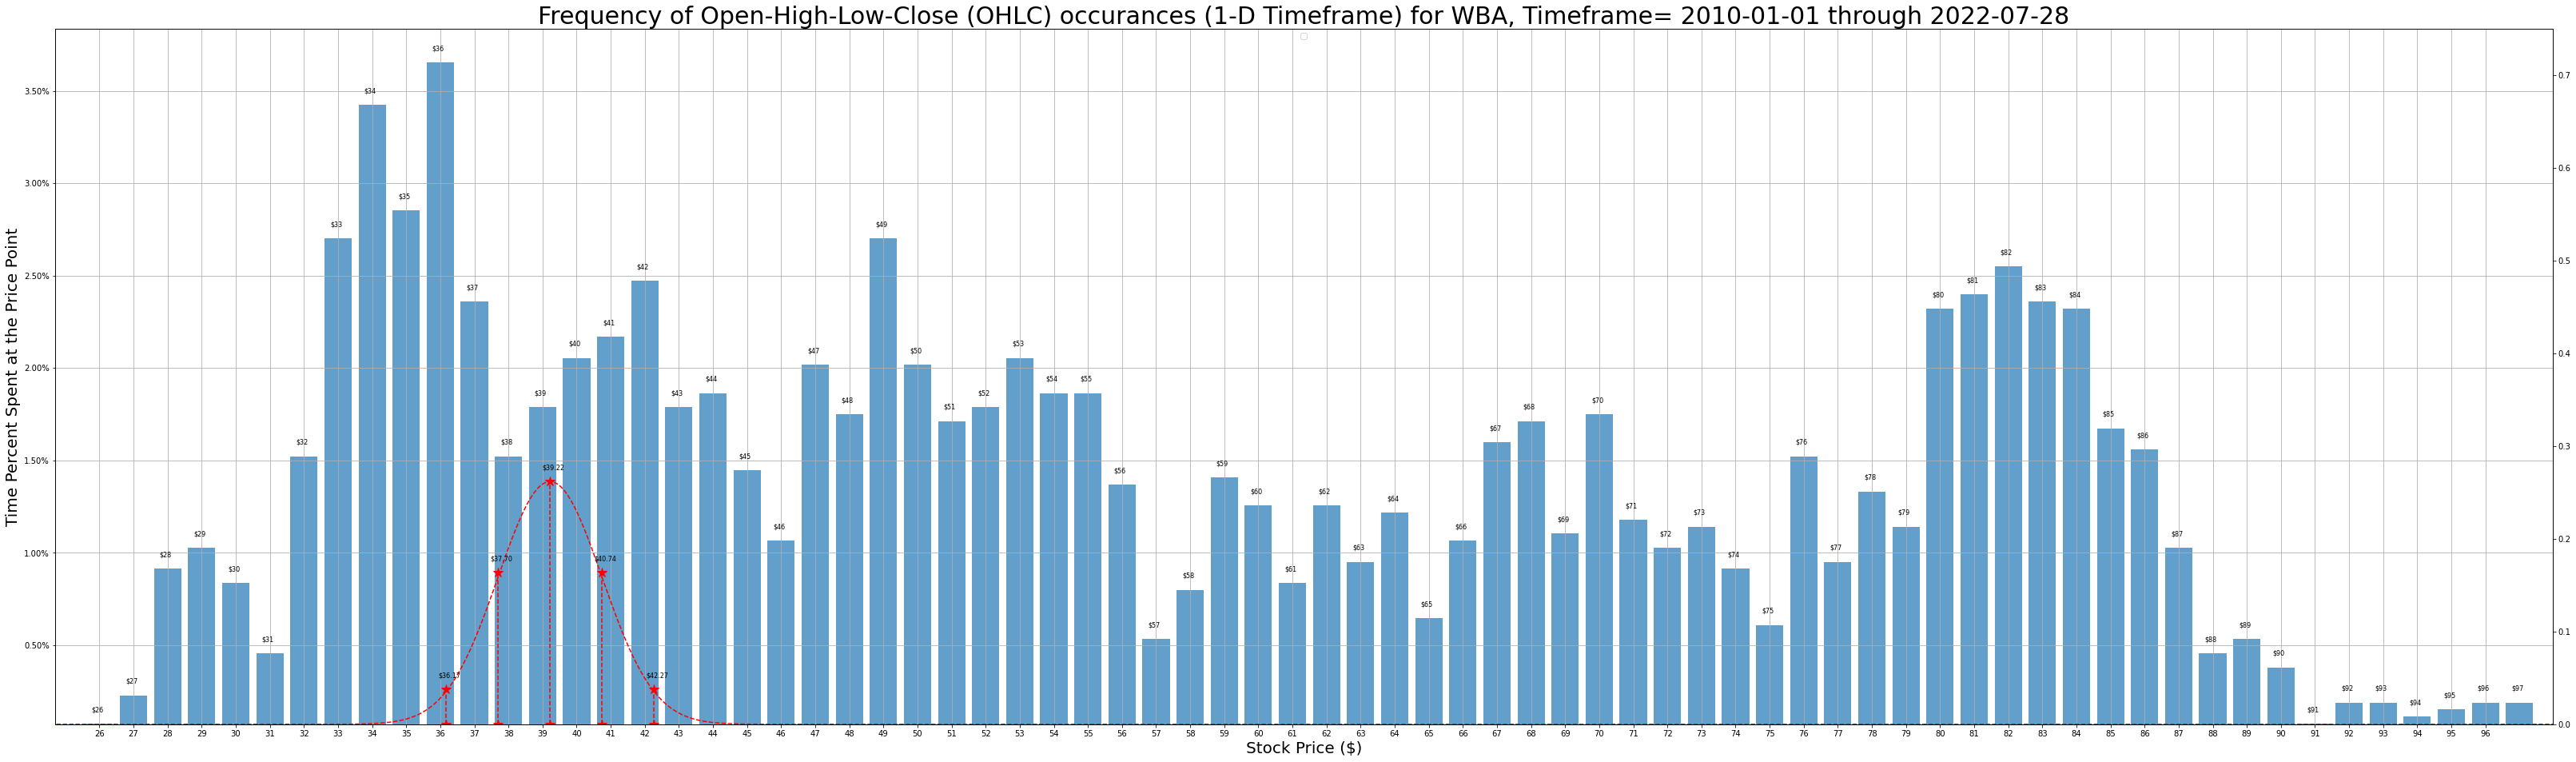

In [46]:
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from scipy import stats
from datetime import date
import math


# Input Variables 

ticker="WBA"
start_date="2010-01-01"
end_date=date.today()
interval="1wk"
base=1

# Download Historical Data from Yahoo Finance
def get_stock_data(ticker, start_date, end_date, interval):
    df = yf.download(ticker, start_date, end_date, interval=interval).dropna()
    return(df)

# Extract the last available Closing Price
def get_last_price(df):
    last_price=df.Close[len(df.Close)-1]
    return(last_price)

# Calcualate Log Return and Standard Deviation of the Log Return
def get_st_dev(df):
    df['log_r'] = np.log(df.Close) - np.log(df.Close.shift(1))
    st_dev_pct=np.std(df.log_r)
    return(st_dev_pct)

# Round historical data to the specified base
def round_data(df, base):
    df = base*round(df/base)
    return(df)

# Count Number of Opens, Highs, Lows and Closes for each price point
def group_data(df):
    df['Date']=df.index
    
    # Group by individual OHLC columns
    df_group_open=pd.DataFrame(df.groupby('Open').count().sort_values(by='Date',ascending=False).Date)
    df_group_high=pd.DataFrame(df.groupby('High').count().sort_values(by='Date',ascending=False).Date)
    df_group_low=pd.DataFrame(df.groupby('Low').count().sort_values(by='Date',ascending=False).Date)
    df_group_close=pd.DataFrame(df.groupby('Close').count().sort_values(by='Date',ascending=False).Date)
    
    # Join OHLC columns
    df=df_group_open.join(df_group_high, how='outer',rsuffix='o', sort=True)
    df=df.join(df_group_low, how='outer', rsuffix='h', sort=True)
    df=df.join(df_group_close, how='outer', rsuffix='l', sort=True).fillna(0)
    
    # Sum and name OHLC columns
    df['total']=df.sum(axis=1)
    df.columns=['Count_Open', 'Count_High', 'Count_Low', 'Count_Close', 'Count_Sum']
    df['Count_Sum']=df.Count_Sum/np.sum(df.Count_Sum)
    df.index.name='Price_Level($)'
    df=df.sort_values(by='Count_Sum', ascending=False)

    return(df)

# Plot the Grouped Data
def plot_data(df, ticker, start_date, end_date, base):
    
    fig, ax = plt.subplots()
    #Set X and Y
    X=df.index
    Y=df.Count_Sum
    # Create bar plot
    ax.bar(X,Y,alpha=0.7)
    # Add Grid
    ax.grid()
    # Resize
    fig.set_size_inches(56, 16)
    # Add X-ticks
    ax.xaxis.set_ticks(np.arange(np.min(X),np.max(X), base))
    # Add Y-ticks
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
    #ax.yaxis.set_ticks(np.arange(0,np.max(Y)))
    # Set X-label
    ax.set_xlabel('Price ($)', size=15)
    # Set Y-label
    ax.set_ylabel('Time Percent Spent at the Price Point', size=15)
    # Set Title
    ax.set_title('Frequency of Open-High-Low-Close (OHLC) occurances (1-D Timeframe) for '
                 +ticker+', Timeframe= '+str(start_date)+' through '+str(end_date),size=30)
    #Add data labels
    for x,y in zip(X,Y):
        label = "${:.0f}".format(x)
        plt.annotate(label, # this is the text
                     (x,y), # these are the coordinates to position the label
                     textcoords="offset points", # how to position the text
                     xytext=(-10,15), # distance from text to points (x,y)
                     fontsize=8,
                     ha='left') # horizontal alignment can be left, right or center
    # Set axes limits
    ax.set_xlim(np.min(X)*0.95,np.max(X)*1.01)
    ax.set_ylim(np.min(Y)*0.95, np.max(Y)*1.05)
    # Add legend
    leg = plt.legend(loc='upper center')
    return(fig, ax)

def plot_normal(fig, ax, last_price, st_dev_pct):    
    # Add second Y-axis
    ax1=ax.twinx()
    mu=last_price
    st_dev_dollar = st_dev_pct * last_price
    snd=stats.norm(mu, st_dev_dollar)
    
    # Random variable X having different values
    x = np.linspace(0, 100, 1000)
    y = snd.pdf(x)
    
    # Plotting different normal distribution curves simultaneously
    ax1.plot(x, y, '--r') 
    ax1.set_ylim(0, 0.75)
    
    sigmas = [mu,
              mu + st_dev_dollar,
              mu + st_dev_dollar*2,
              mu - st_dev_dollar,
              mu - st_dev_dollar*2]

    heights = [np.max(y), 
               np.max(y)/1.6,
               np.max(y)/7,
               np.max(y)/1.6,
               np.max(y)/7]
    
    for x,y in zip(sigmas, heights):
        ax1.plot([x, x],
                 [0, y],
                 '--*r',
                 markersize=12)
        
        plt.annotate("${:.2f}".format(x),
                    (x,y),
                    textcoords="offset points", 
                    xytext=(-10,15),
                    fontsize=8,
                    ha='left')
            
    return(ax.plot)
    
def execute():
    df=get_stock_data(ticker, start_date, end_date, interval)
    last_price=get_last_price(df)
    st_dev_pct=get_st_dev(df)
    df=round_data(df, base)
    df=group_data(df)
    df.to_csv('Price_Level_Significance_'+ticker+'_'+str(start_date)+'_'+str(end_date)+'.csv')
    fig, ax = plot_data(df, ticker, start_date, end_date, base)
    plot_normal(fig, ax, last_price, st_dev_pct)
    print(df)
    
if __name__ == '__main__':
    execute()    